In [23]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# To see all columns
pd.set_option('display.max_columns', None)

In [3]:
# Importing data
pitches_22 = pd.read_csv('updated_pitches_22.csv')
pitches_23 = pd.read_csv('updated_pitches_23.csv')
pitches_24 = pd.read_csv('updated_pitches_24.csv')

# Combine them
pitches_total = pd.concat([pitches_22, pitches_23, pitches_24])

In [4]:
# Organizing rows by game, at bat
pitches_total_sorted = pitches_total.sort_values(['gameid', 'ab', 'pitchnum']).reset_index(drop=True)

## Preliminary Analysis

In [5]:
pitches_total_sorted.head()

,gameid,GameDate,ab,pitchnum,inning,teambat,balls,strikes,outs,visscore,homscore,pitcher,pitcherthrows,batter,batterside,pitchresult,pitchresult_desc,eventtype,metrics_pitching_position,pitchname,pitchname_desc,spinrate,relspeed,horzbreak,inducedvertbreak,vertbreak,platelocside,platelocheight,ExitSpeed,VExitAngle,HExitAngle,initposx,initposy,initposz,hometeam_id,Home,awayteam_id,Visitor,venue_id,venue_name,video_broadcast
0,2022/04/07/cinmlb-atlmlb-1,08:00.0,1,1,1,0,0,0,0,0,0,"Fried, Max",L,"India, John",R,C,Strike - Called,called_strike,Stretch,FF,Four-seam FB,2186.985,95.80275,-3.227400,16.20755,-13.53874,-0.221043,2.266654,NaN,NaN,NaN,0.976,50,6.027,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...
1,2022/04/07/cinmlb-atlmlb-1,08:00.0,1,2,1,0,0,1,0,0,0,"Fried, Max",L,"India, John",R,C,Strike - Called,called_strike,Stretch,SI,Sinker,2271.806,97.70222,-7.665975,11.77926,-16.81612,0.114371,1.924395,NaN,NaN,NaN,0.889,50,6.065,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...
2,2022/04/07/cinmlb-atlmlb-1,08:00.0,1,3,1,0,0,2,0,0,0,"Fried, Max",L,"India, John",R,S,Strike - Swinging,strikeout,Stretch,FF,Four-seam FB,2305.888,97.51570,-3.390407,11.58729,-17.03338,-0.605712,3.348813,NaN,NaN,NaN,0.950,50,6.203,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...
3,2022/04/07/cinmlb-atlmlb-1,08:00.0,2,1,1,0,0,0,1,0,0,"Fried, Max",L,"Aquino, Aristides",R,C,Strike - Called,called_strike,Stretch,CU,Curveball,2666.945,75.29880,10.010420,-13.76583,-62.21450,-0.269820,2.767712,NaN,NaN,NaN,1.223,50,6.360,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...
4,2022/04/07/cinmlb-atlmlb-1,08:00.0,2,2,1,0,0,1,1,0,0,"Fried, Max",L,"Aquino, Aristides",R,B,Ball - Called,ball,Stretch,CU,Curveball,2738.431,76.38889,9.170583,-14.35002,-61.40285,0.737719,2.921426,NaN,NaN,NaN,1.293,50,6.503,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...


In [6]:
# See what NULLS we are working with
print(pitches_total.isna().sum())

gameid                             0
GameDate                           0
ab                                 0
pitchnum                           0
inning                             0
teambat                            0
balls                              0
strikes                            0
outs                               0
visscore                           0
homscore                           0
pitcher                            0
pitcherthrows                      0
batter                             0
batterside                         0
pitchresult                        0
pitchresult_desc                   0
eventtype                          0
metrics_pitching_position       6080
pitchname                          0
pitchname_desc                     0
spinrate                        6749
relspeed                           4
horzbreak                          0
inducedvertbreak                   0
vertbreak                          5
platelocside                       0
p

There are ~6000 missing values for pitching position, ~7000 for spinrate, ~1700 for initial position x, z, but 0 for y. Venue_name is missing 273 values

In [ ]:
# Pitch result descriptions
set(pitches_total['pitchresult_desc'])

{'Ball - Ball In Dirt',
 'Ball - Called',
 'Ball - Hit by Pitch',
 'Ball - Pitchout',
 'Hit Into Play - No Out(s)',
 'Hit Into Play - Out(s)',
 'Hit Into Play - Run(s)',
 'Pitchout Hit Into Play - Out(s)',
 'Strike - Bunt Foul Tip',
 'Strike - Called',
 'Strike - Foul',
 'Strike - Foul Bunt',
 'Strike - Foul Tip',
 'Strike - Missed Bunt',
 'Strike - Swinging',
 'Strike - Swinging Blocked',
 'Strike - Unknown'}

We want to work with grounded into double play batted ball profiles, so let's filter for plays where there was a 
grounded into double play

# Finding Most Optimal GIDP Contact -- MULTIPLE TYPES

In [7]:
dps = pitches_total[pitches_total['eventtype'] == 'grounded_into_double_play']
# We have ~10,000 instances of GIDP, so we can work with this

In [ ]:
# 10_041 grounded into double plays instances
len(dps)

10041

<Axes: xlabel='ExitSpeed', ylabel='Density'>

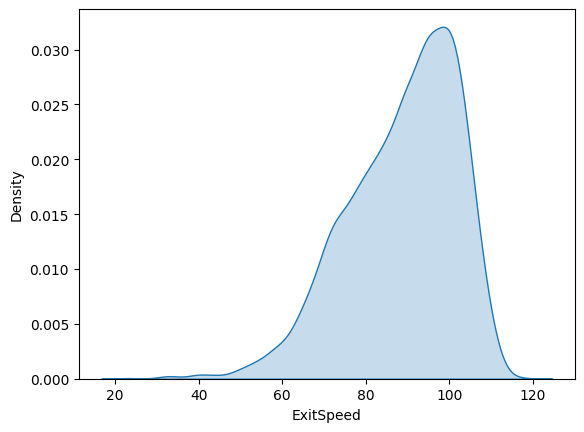

In [ ]:
# GIDP batted ball profile distributions 
sns.kdeplot(dps['ExitSpeed'], fill=True)

In [ ]:
np.mean(dps['ExitSpeed']), np.nanmedian(dps['ExitSpeed'])

(np.float64(88.63146425814837), np.float64(90.858215))

<Axes: xlabel='ExitSpeed', ylabel='Density'>

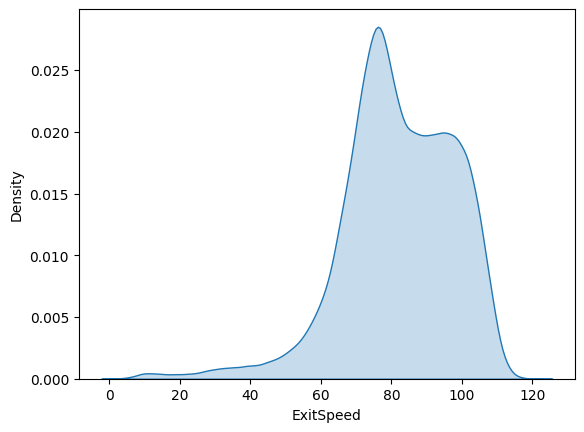

In [14]:
sns.kdeplot(pitches_total_sorted['ExitSpeed'], fill=True)

<Axes: xlabel='VExitAngle', ylabel='Density'>

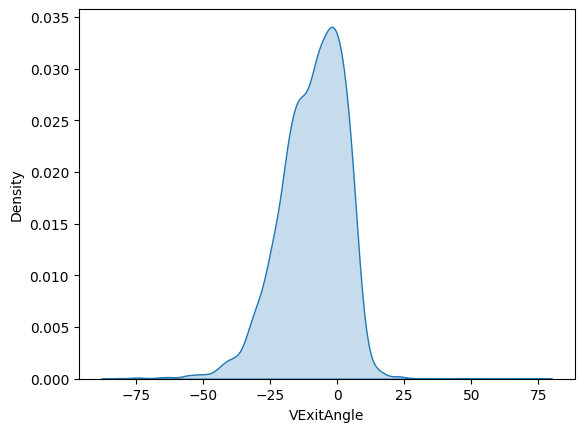

In [11]:
sns.kdeplot(dps['VExitAngle'], fill=True)

<Axes: xlabel='HExitAngle', ylabel='Density'>

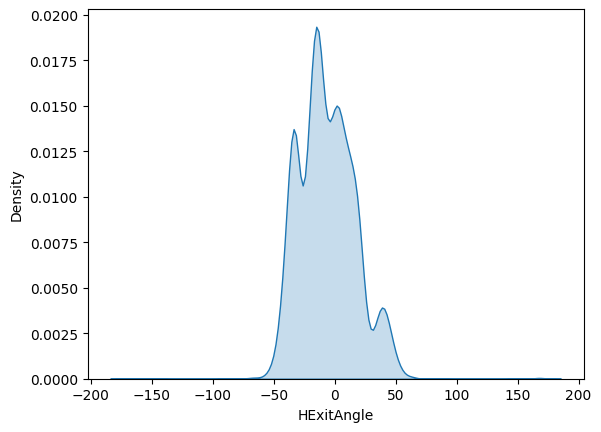

In [12]:
sns.kdeplot(dps['HExitAngle'], fill=True)

<Axes: xlabel='HExitAngle', ylabel='Density'>

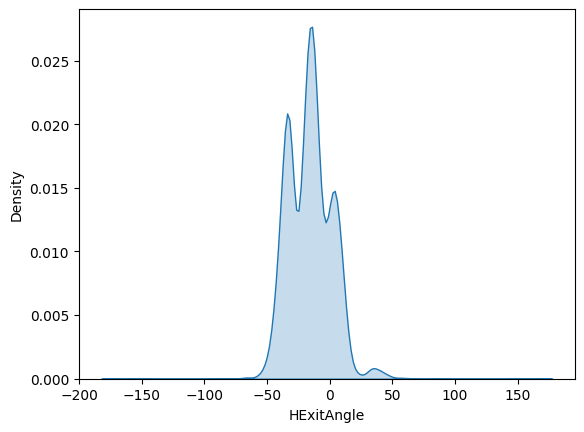

In [43]:
# Right handed hitters HExitAngle
sns.kdeplot(dps[dps['batterside'] == 'R']['HExitAngle'], fill=True)


<Axes: xlabel='HExitAngle', ylabel='Density'>

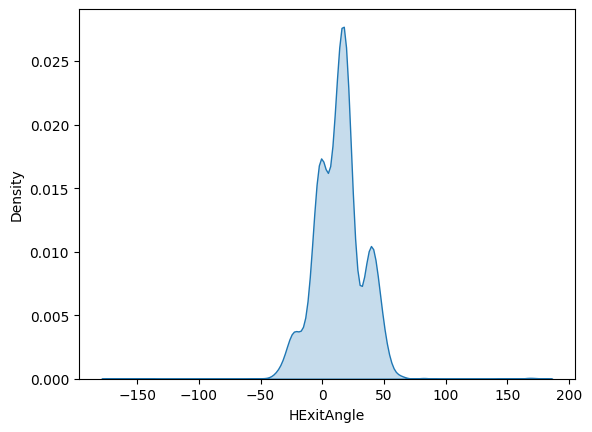

In [44]:
sns.kdeplot(dps[dps['batterside'] == 'L']['HExitAngle'], fill=True)

## Right-handed Hitters Optimal GIDP Contact

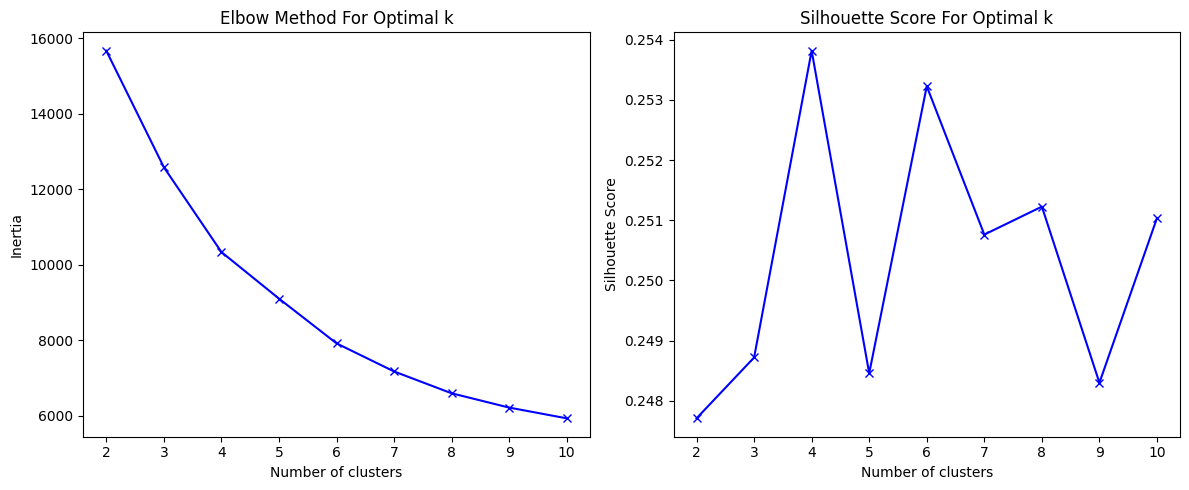

In [127]:
X_right = dps[dps['batterside'] == 'R'][['ExitSpeed', 'VExitAngle', 'HExitAngle']].dropna()

# Scale data
scaler_right = StandardScaler()
X_right_scaled = scaler_right.fit_transform(X_right)
# Determine optimal number of clusters using the elbow method and silhouette score
inertia = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_right_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_right_scaled, kmeans.labels_))

# Plotting the elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

# Plotting the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.tight_layout()
plt.show()

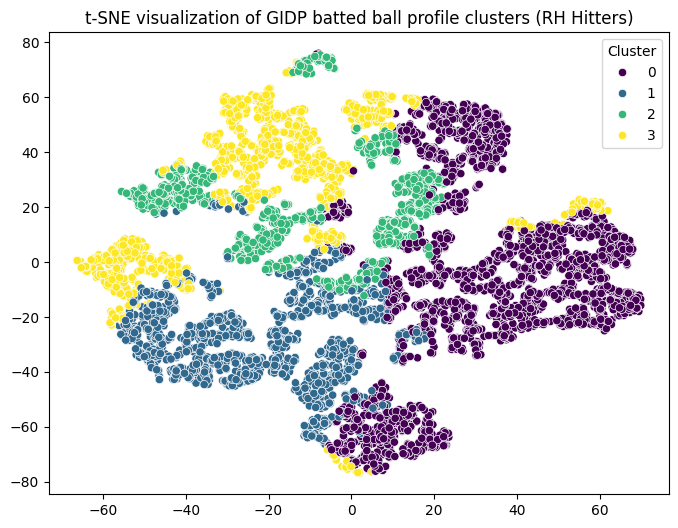

In [129]:
k = 4
kmeans_right = KMeans(n_clusters=k, n_init=50, random_state=42)
X_right['Cluster'] = kmeans_right.fit_predict(X_right_scaled)

tsne_right = TSNE(
    n_components=2, # 2D projection
    perplexity=40, # 30-50 is good here
    random_state=1236,
    n_jobs=-1
)

X_tsne_right = tsne_right.fit_transform(X_right_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne_right[:, 0], y=X_tsne_right[:, 1], hue=X_right['Cluster'], palette='viridis')
plt.title('t-SNE visualization of GIDP batted ball profile clusters (RH Hitters)')
plt.show()

## Left-handed Hitters Optimal GIDP Contact

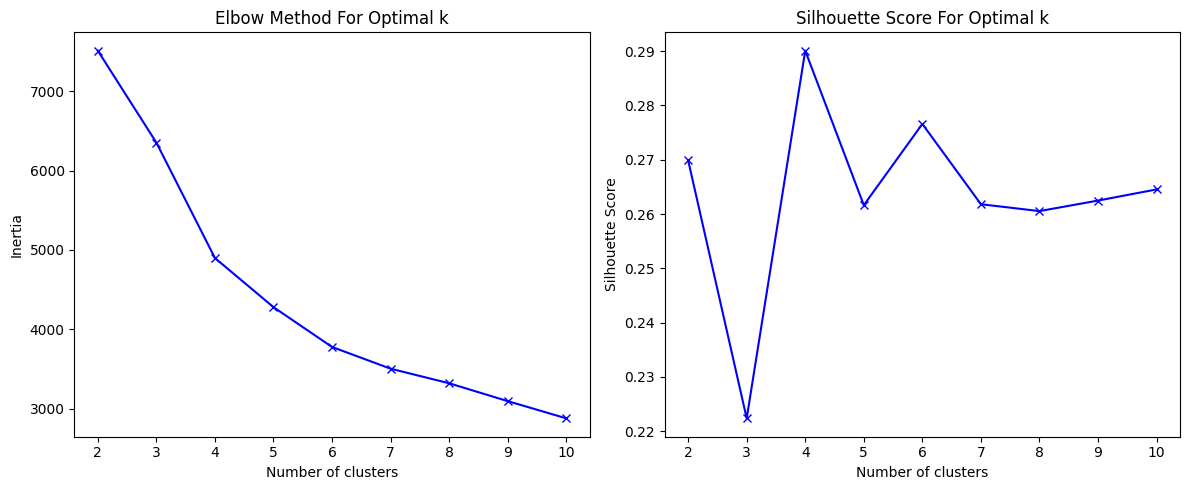

In [128]:
X_left = dps[dps['batterside'] == 'L'][['ExitSpeed', 'VExitAngle', 'HExitAngle']].dropna()
# Determine optimal number of clusters using the elbow method and silhouette score
# Scale data
scaler_left = StandardScaler()
X_left_scaled = scaler_left.fit_transform(X_left)
inertia = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_left_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_left_scaled, kmeans.labels_))

# Plotting the elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
# Plotting the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.tight_layout()
plt.show()

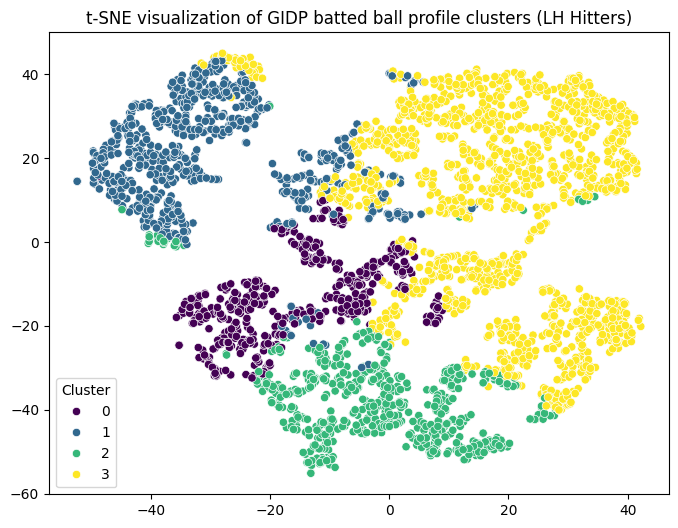

In [130]:
# K is 5 
k = 4
kmeans_left = KMeans(n_clusters=k, n_init=50, random_state=42)
X_left['Cluster'] = kmeans_left.fit_predict(X_left_scaled)

tsne_left = TSNE(
    n_components=2, # 2D projection
    perplexity=40, # 30-50 is good here
    random_state=1236,
    n_jobs=-1
)

X_tsne_left = tsne_right.fit_transform(X_left_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne_left[:, 0], y=X_tsne_left[:, 1], hue=X_left['Cluster'], palette='viridis')
plt.title('t-SNE visualization of GIDP batted ball profile clusters (LH Hitters)')
plt.show()

## Overall KMeans (all hitters)

Text(0.5, 1.0, 'Elbow Method For Optimal k')

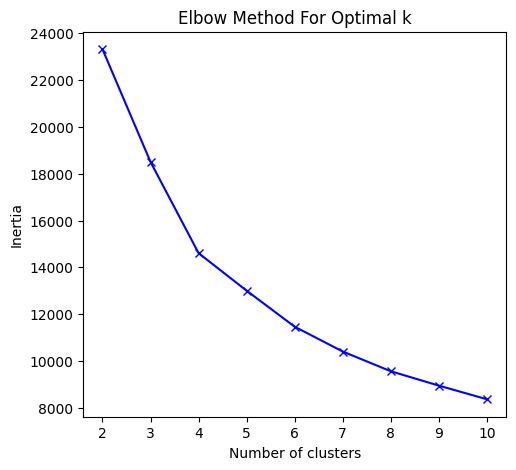

In [109]:
# KMeans to find GIDP batted ball profile clusters
# Using exit speed, vertical exit angle, horizontal exit angle
X = dps[['ExitSpeed', 'VExitAngle', 'HExitAngle']].dropna()
# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Determine optimal number of clusters using the elbow method and silhouette score
inertia = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plotting the elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

In [110]:
k = 5
kmeans_overall = KMeans(n_clusters=k, n_init=50, random_state=42)
X['Cluster'] = kmeans_overall.fit_predict(X_scaled)

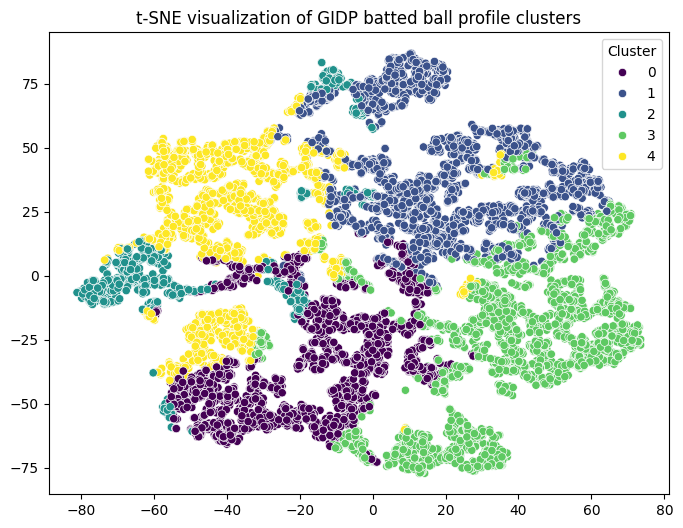

In [111]:
# Plotting with the clusters with tSNE

tsne = TSNE(
    n_components=2, # 2D projection
    perplexity=40, # 30-50 is good here
    random_state=1236,
    n_jobs=-1
)

X_tsne = tsne.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=X['Cluster'], palette='viridis')
plt.title('t-SNE visualization of GIDP batted ball profile clusters')
plt.show()

## Exploring Each Cluster

In [134]:
# Right-handed clusters

RHH_cluster_0 = X_right[X_right['Cluster'] == 0]
RHH_cluster_1 = X_right[X_right['Cluster'] == 1]
RHH_cluster_2 = X_right[X_right['Cluster'] == 2]
RHH_cluster_3 = X_right[X_right['Cluster'] == 3]


# Left-handed clusters
LHH_cluster_0 = X_left[X_left['Cluster'] == 0]
LHH_cluster_1 = X_left[X_left['Cluster'] == 1]
LHH_cluster_2 = X_left[X_left['Cluster'] == 2]
LHH_cluster_3 = X_left[X_left['Cluster'] == 3]

# Cluster summaries for RHH
for i in range(4):
    cluster = X_right[X_right['Cluster'] == i]
    print(f"RHH Cluster {i}:")
    print(cluster.describe())
    print("\n")

for j in range(4):
    cluster = X_left[X_left['Cluster'] == j]
    print(f"LHH Cluster {j}:")
    print(cluster.describe())
    print("\n")

RHH Cluster 0:
         ExitSpeed   VExitAngle   HExitAngle  Cluster
count  2687.000000  2687.000000  2687.000000   2687.0
mean     99.362196    -4.842334   -14.179943      0.0
std       5.747305     7.001893    12.903886      0.0
min      85.199830   -26.713250   -42.847060      0.0
25%      95.158215    -9.670690   -21.132125      0.0
50%      99.599200    -4.050654   -14.615790      0.0
75%     103.479650     0.581541    -7.599338      0.0
max     118.319200     9.480888    33.365910      0.0


RHH Cluster 1:
         ExitSpeed   VExitAngle   HExitAngle  Cluster
count  1552.000000  1552.000000  1552.000000   1552.0
mean     86.097209   -18.845128   -33.774456      1.0
std      10.431868     9.088474    10.718811      0.0
min      44.046710   -82.071480  -173.132600      1.0
25%      79.568242   -24.102892   -39.867252      1.0
50%      87.366935   -17.786245   -34.335320      1.0
75%      93.416803   -12.517235   -26.929212      1.0
max     110.140400     1.745070   -13.576870      

### Visualizations of Clusters

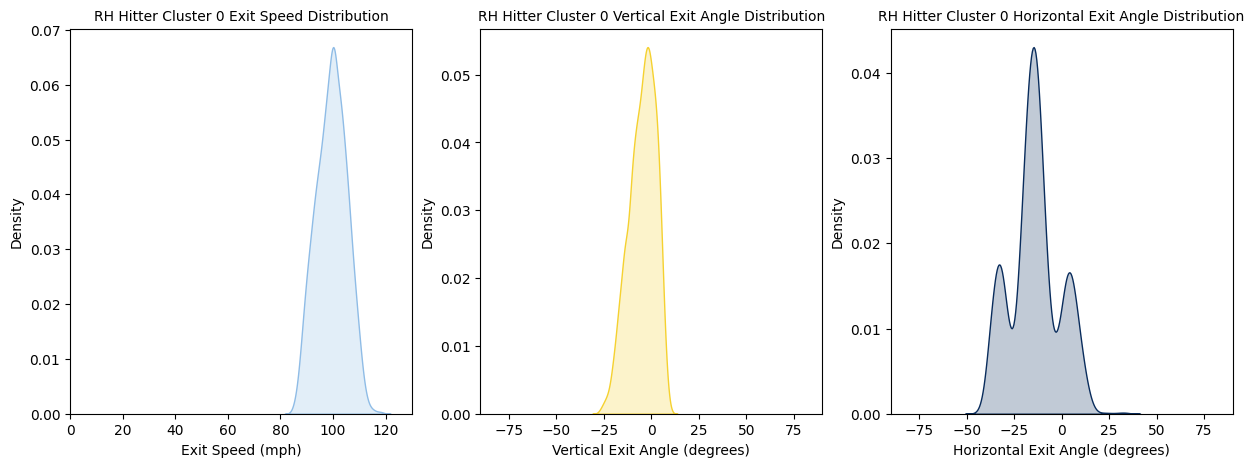

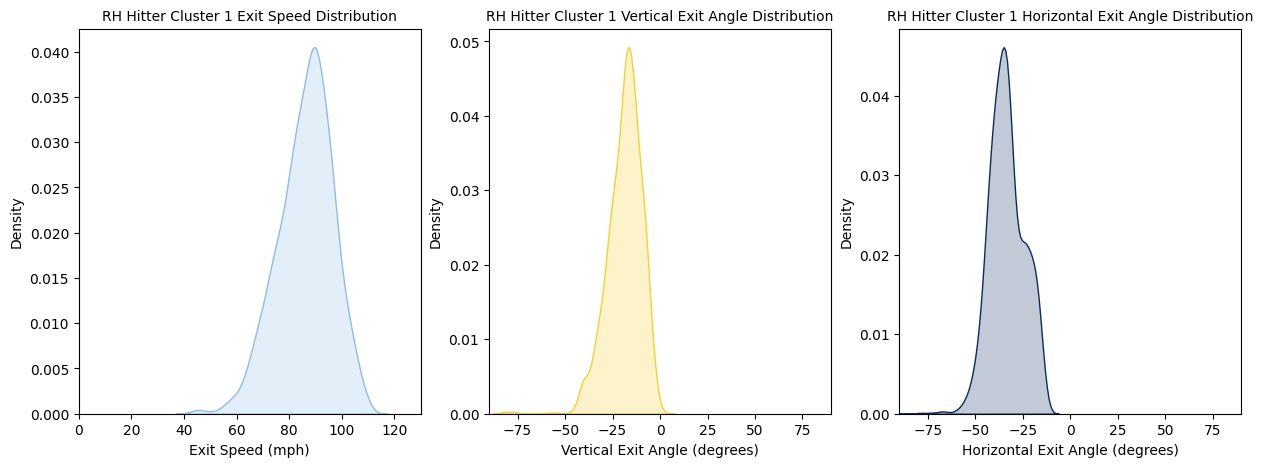

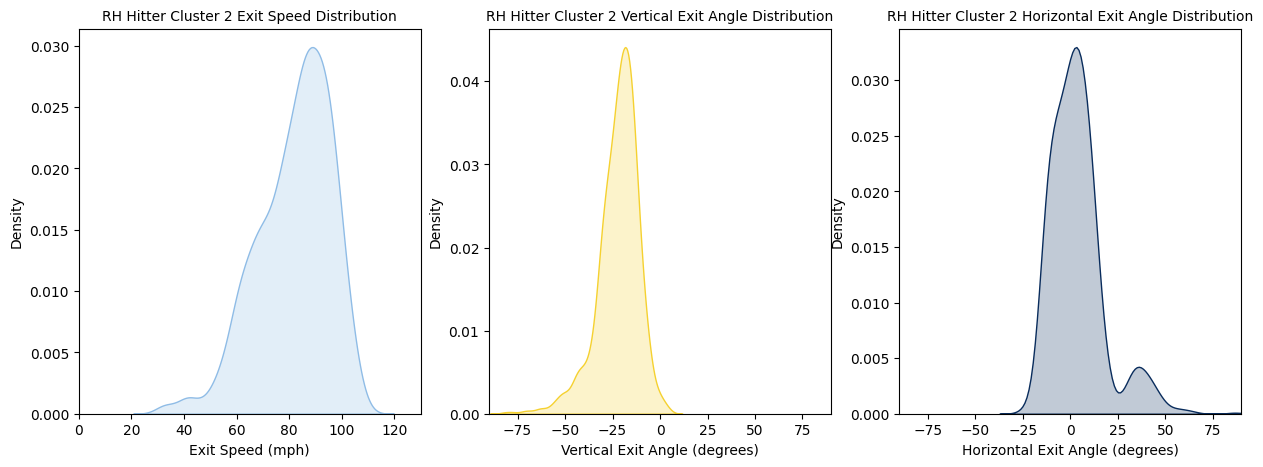

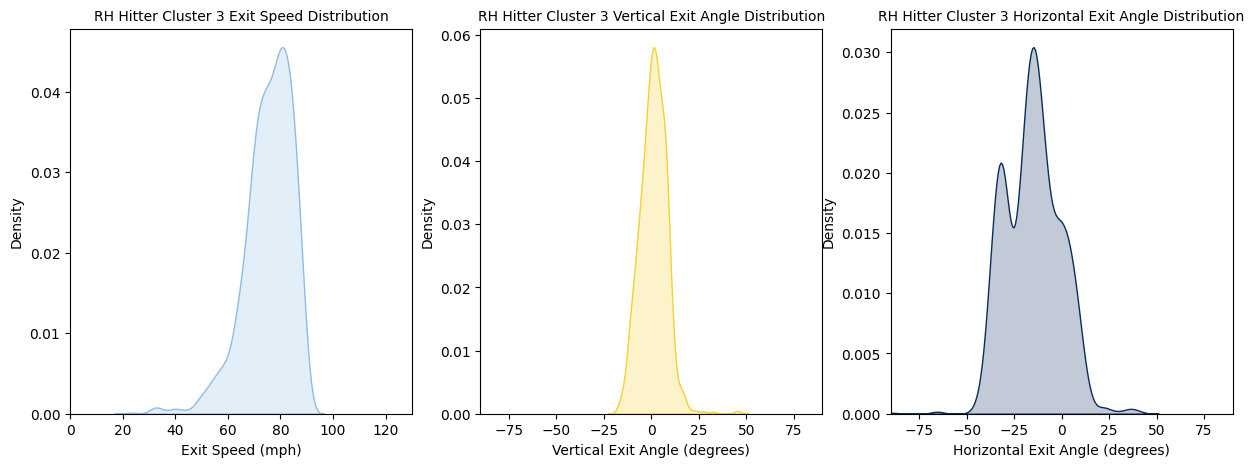

In [ ]:
# Plotting densities for each cluster RHH

for i in range(4):
    cluster = X_right[X_right['Cluster'] == i]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3,  1)
    sns.kdeplot(cluster['ExitSpeed'], fill=True, color='#8FBCE6')
    plt.title(f'RH Hitter Cluster {i} Exit Speed Distribution', fontsize=10)
    plt.xlabel('Exit Speed (mph)')
    plt.xlim(0, 130)
    plt.subplot(1, 3, 2)
    sns.kdeplot(cluster['VExitAngle'], fill=True, color='#F5D130')
    plt.title(f'RH Hitter Cluster {i} Vertical Exit Angle Distribution', fontsize=10)
    plt.xlabel('Vertical Exit Angle (degrees)')
    plt.xlim(-90, 90)
    plt.subplot(1, 3, 3)
    sns.kdeplot(cluster['HExitAngle'], fill=True, color='#092C5C')
    plt.title(f'RH Hitter Cluster {i} Horizontal Exit Angle Distribution', fontsize=10)
    plt.xlabel('Horizontal Exit Angle (degrees)')
    plt.xlim(-90, 90)
    plt.show()

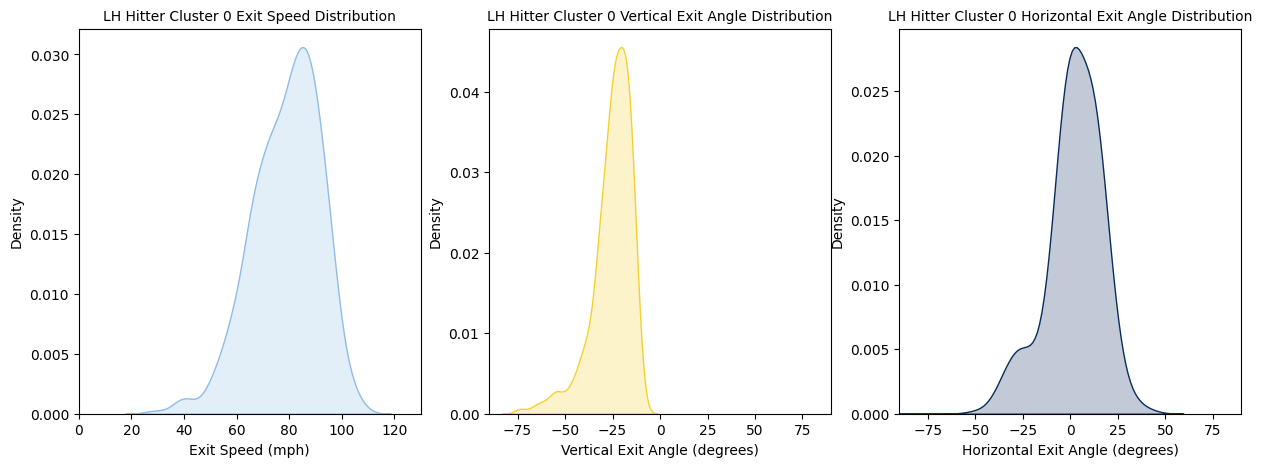

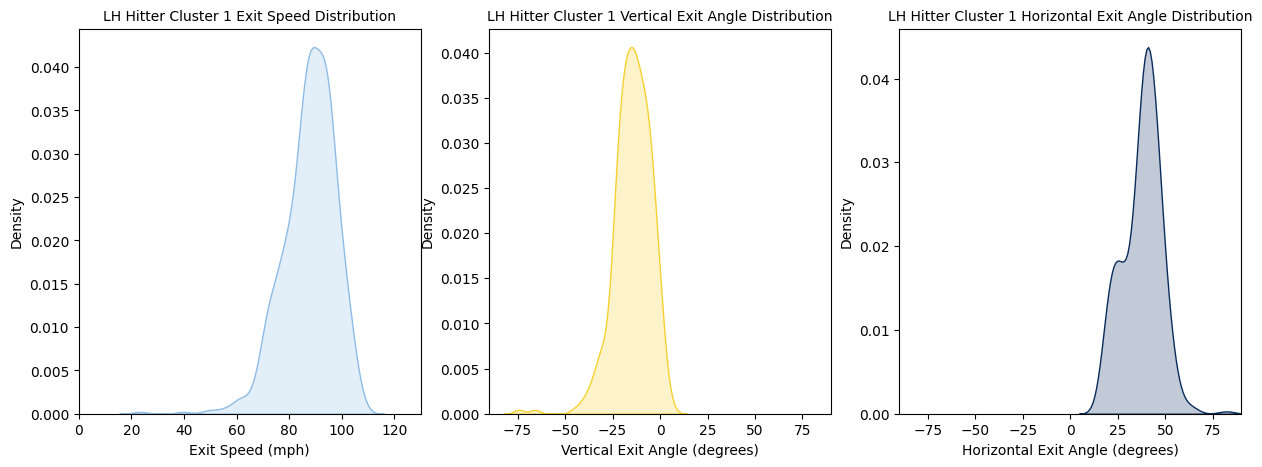

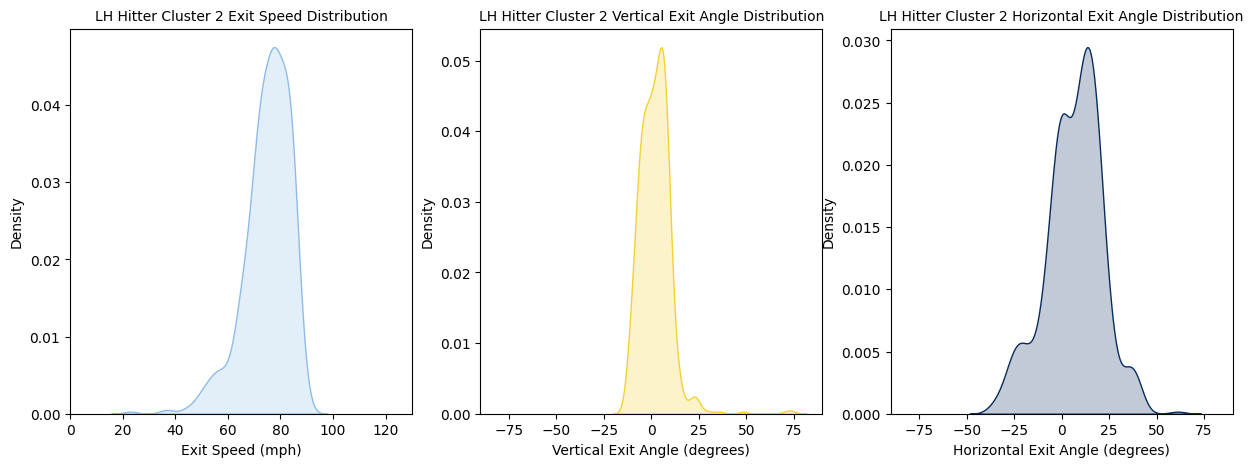

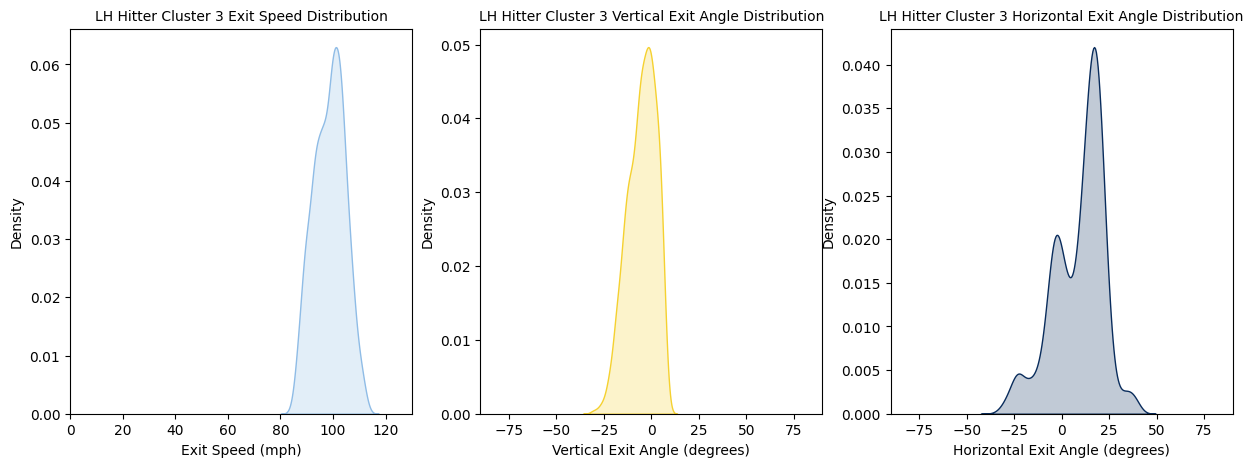

In [246]:
# Plotting densities for each cluster (LHH)

for j in range(4):
    cluster = X_left[X_left['Cluster'] == j]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.kdeplot(cluster['ExitSpeed'], fill=True, color='#8FBCE6')
    plt.title(f'LH Hitter Cluster {j} Exit Speed Distribution', fontsize=10)
    plt.xlabel('Exit Speed (mph)')
    plt.xlim(0, 130)
    plt.subplot(1, 3, 2)
    sns.kdeplot(cluster['VExitAngle'], fill=True, color='#F5D130')
    plt.title(f'LH Hitter Cluster {j} Vertical Exit Angle Distribution', fontsize=10)
    plt.xlabel('Vertical Exit Angle (degrees)')
    plt.xlim(-90, 90)
    plt.subplot(1, 3, 3)
    sns.kdeplot(cluster['HExitAngle'], fill=True, color='#092C5C')
    plt.title(f'LH Hitter Cluster {j} Horizontal Exit Angle Distribution', fontsize=10)
    plt.xlabel('Horizontal Exit Angle (degrees)')
    plt.xlim(-90, 90)
    plt.show()

In [226]:
# Converting right, left handed dataframes to CSVs for export
X_right.to_csv('RHH_GIDP_ByCluster.csv', index=False)
X_left.to_csv('LHH_GIDP_ByCluster.csv', index=False)

In [135]:
# Cluster Centers for Right, Left, Overall
print("RHH Cluster Centers:")
print(scaler_right.inverse_transform(kmeans_right.cluster_centers_))
print("\nLHH Cluster Centers:")
print(scaler_left.inverse_transform(kmeans_left.cluster_centers_))
print("\nOverall Cluster Centers:")
print(scaler.inverse_transform(kmeans_overall.cluster_centers_))

RHH Cluster Centers:
[[ 99.3701297   -4.83551716 -14.14711427]
 [ 86.11928029 -18.79490621 -33.76577248]
 [ 81.866078   -22.20993281   3.94977767]
 [ 75.33334444   1.0250651  -15.16856437]]

LHH Cluster Centers:
[[ 78.77920527 -25.50556311   0.97556426]
 [ 87.57657324 -14.58908721  38.36196911]
 [ 74.89338081   1.98057596   6.56766404]
 [ 98.52914767  -5.12976042   8.93931199]]

Overall Cluster Centers:
[[ 88.69137824 -20.41349573 -25.12142272]
 [ 94.84154248  -8.53942141  18.97353404]
 [ 70.05048507 -28.81980708   9.76332868]
 [ 98.72117362  -3.00819281 -17.61914902]
 [ 74.03610446   0.69599862 -10.03238619]]


## Given the Cluster Centers, Find Sweet Spot:

In [ ]:
# Middle 80% of All 3 Variables as Sweet Spot for each GIDP Profile
# RIGHT HANDED
# Cluster 0
mid_50_right_0_ev = np.percentile(RHH_cluster_0['ExitSpeed'], [10, 90], axis=0)
mid_50_right_0_vla = np.percentile(RHH_cluster_0['VExitAngle'], [10, 90], axis=0)
mid_50_right_0_hla = np.percentile(RHH_cluster_0['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_right_0 = [mid_50_right_0_ev, mid_50_right_0_vla, mid_50_right_0_hla]
# Cluster 1
mid_50_right_1_ev = np.percentile(RHH_cluster_1['ExitSpeed'], [10, 90], axis=0)
mid_50_right_1_vla = np.percentile(RHH_cluster_1['VExitAngle'], [10, 90], axis=0)
mid_50_right_1_hla = np.percentile(RHH_cluster_1['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_right_1 = [mid_50_right_1_ev, mid_50_right_1_vla, mid_50_right_1_hla]
# Cluster 2
mid_50_right_2_ev = np.percentile(RHH_cluster_2['ExitSpeed'], [10, 90], axis=0)
mid_50_right_2_vla = np.percentile(RHH_cluster_2['VExitAngle'], [10, 90], axis=0)
mid_50_right_2_hla = np.percentile(RHH_cluster_2['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_right_2 = [mid_50_right_2_ev, mid_50_right_2_vla, mid_50_right_2_hla]
# Cluster 3
mid_50_right_3_ev = np.percentile(RHH_cluster_3['ExitSpeed'], [10, 90], axis=0)
mid_50_right_3_vla = np.percentile(RHH_cluster_3['VExitAngle'], [10, 90], axis=0)
mid_50_right_3_hla = np.percentile(RHH_cluster_3['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_right_3 = [mid_50_right_3_ev, mid_50_right_3_vla, mid_50_right_3_hla]

# LEFT HANDED
# Cluster 0
mid_50_left_0_ev = np.percentile(LHH_cluster_0['ExitSpeed'], [10, 90], axis=0)
mid_50_left_0_vla = np.percentile(LHH_cluster_0['VExitAngle'], [10, 90], axis=0)
mid_50_left_0_hla = np.percentile(LHH_cluster_0['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_left_0 = [mid_50_left_0_ev, mid_50_left_0_vla, mid_50_left_0_hla]
# Cluster 1
mid_50_left_1_ev = np.percentile(LHH_cluster_1['ExitSpeed'], [10, 90], axis=0)
mid_50_left_1_vla = np.percentile(LHH_cluster_1['VExitAngle'], [10, 90], axis=0)
mid_50_left_1_hla = np.percentile(LHH_cluster_1['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_left_1 = [mid_50_left_1_ev, mid_50_left_1_vla, mid_50_left_1_hla]
# Cluster 2
mid_50_left_2_ev = np.percentile(LHH_cluster_2['ExitSpeed'], [10, 90], axis=0)
mid_50_left_2_vla = np.percentile(LHH_cluster_2['VExitAngle'], [10, 90], axis=0)
mid_50_left_2_hla = np.percentile(LHH_cluster_2['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_left_2 = [mid_50_left_2_ev, mid_50_left_2_vla, mid_50_left_2_hla]
# Cluster 3
mid_50_left_3_ev = np.percentile(LHH_cluster_3['ExitSpeed'], [10, 90], axis=0)
mid_50_left_3_vla = np.percentile(LHH_cluster_3['VExitAngle'], [10, 90], axis=0)
mid_50_left_3_hla = np.percentile(LHH_cluster_3['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_left_3 = [mid_50_left_3_ev, mid_50_left_3_vla, mid_50_left_3_hla]

rhh_GIDP_sweet_spots = {
    'Cluster 0': sweet_spot_right_0,
    'Cluster 1': sweet_spot_right_1,
    'Cluster 2': sweet_spot_right_2,
    'Cluster 3': sweet_spot_right_3
}

lhh_GIDP_sweet_spots = {
    'Cluster 0': sweet_spot_left_0,
    'Cluster 1': sweet_spot_left_1,
    'Cluster 2': sweet_spot_left_2,
    'Cluster 3': sweet_spot_left_3

}

print("RHH GIDP Sweet Spots (25th to 75th Percentile Ranges):")
for cluster, ranges in rhh_GIDP_sweet_spots.items():
    print(f"{cluster}: Exit Speed {ranges[0]}, Vertical Launch Angle {ranges[1]}, Horizontal Launch Angle {ranges[2]}")
print("\nLHH GIDP Sweet Spots (25th to 75th Percentile Ranges):")
for cluster, ranges in lhh_GIDP_sweet_spots.items():
    print(f"{cluster}: Exit Speed {ranges[0]}, Vertical Launch Angle {ranges[1]}, Horizontal Launch Angle {ranges[2]}")

RHH GIDP Sweet Spots (25th to 75th Percentile Ranges):
Cluster 0: Exit Speed [ 91.493202 106.80714 ], Vertical Launch Angle [-14.629816   3.777778], Horizontal Launch Angle [-32.76207     4.7664136]
Cluster 1: Exit Speed [71.823449 98.486125], Vertical Launch Angle [-30.510458   -8.1589445], Horizontal Launch Angle [-44.439125 -20.117655]
Cluster 2: Exit Speed [62.59245 97.79783], Vertical Launch Angle [-35.0108  -10.76243], Horizontal Launch Angle [-11.83852  17.38752]
Cluster 3: Exit Speed [64.101601 85.622455], Vertical Launch Angle [-8.1253666  8.8509701], Horizontal Launch Angle [-33.962174    3.8942582]

LHH GIDP Sweet Spots (25th to 75th Percentile Ranges):
Cluster 0: Exit Speed [62.30026  94.186108], Vertical Launch Angle [-38.75225  -14.857588], Horizontal Launch Angle [-19.718612  18.337096]
Cluster 1: Exit Speed [74.249798 99.211519], Vertical Launch Angle [-25.471699   -3.1915057], Horizontal Launch Angle [22.673271 48.999665]
Cluster 2: Exit Speed [64.27658 84.41721], Vert

# Feature Engineering Sweet-Spots on the entire dataset

We are just going to create a binary classifier problem (at least for now). 

We can always create a multi-class problem to determine whicn types of GIDP each pitch type induces the most.

In [218]:
# First, filter the main dataset to just balls put into play
bip_df = pitches_total_sorted[pitches_total_sorted['pitchresult_desc'].isin(
    ['Hit Into Play - Out(s)', 'Hit Into Play - Run(s)', 'Hit Into Play - No Out(s)'
     ])
 ].copy()

In [ ]:
# Apply a function to determine if each batted ball falls within any of the sweet spots

def is_in_sweet_spot(row, sweet_spots_right=rhh_GIDP_sweet_spots, 
                     sweet_spots_left=lhh_GIDP_sweet_spots, **kwargs):
    '''
    Determines if a batted ball falls within any of the defined sweet spots
    for right-handed or left-handed hitters based on exit velocity, vertical launch angle,
    and horizontal launch angle. This essentially captures whether a batted ball
    has the characteristics of a typical GIDP batted ball profile (many types).

    Params:
    row: A row from the DataFrame
    Returns:
    bool: True if the batted ball falls within any sweet spot, False otherwise
    '''
    ev = row['ExitSpeed']
    vla = row['VExitAngle']
    hla = row['HExitAngle']
    if row['batterside'] == 'R':

        for cluster, ranges in sweet_spots_right.items():
            if (ranges[0][0] <= ev <= ranges[0][1] and
                ranges[1][0] <= vla <= ranges[1][1] and
                ranges[2][0] <= hla <= ranges[2][1]):
                return 1
            
    elif row['batterside'] == 'L':
        for cluster, ranges in sweet_spots_left.items():
            if (ranges[0][0] <= ev <= ranges[0][1] and
                ranges[1][0] <= vla <= ranges[1][1] and
                ranges[2][0] <= hla <= ranges[2][1]):
                return 1
    return 0



In [220]:
# Apply the function to create a new column 'GIDP_SweetSpot'
bip_df['GIDP_SweetSpot'] = bip_df.apply(is_in_sweet_spot, axis=1)

In [221]:
bip_df[bip_df['GIDP_SweetSpot'] == 1]

,gameid,GameDate,ab,pitchnum,inning,teambat,balls,strikes,outs,visscore,homscore,pitcher,pitcherthrows,batter,batterside,pitchresult,pitchresult_desc,eventtype,metrics_pitching_position,pitchname,pitchname_desc,spinrate,relspeed,horzbreak,inducedvertbreak,vertbreak,platelocside,platelocheight,ExitSpeed,VExitAngle,HExitAngle,initposx,initposy,initposz,hometeam_id,Home,awayteam_id,Visitor,venue_id,venue_name,video_broadcast,GIDP_SweetSpot
72,2022/04/07/cinmlb-atlmlb-1,08:00.0,23,2,3,1,1,0,0,3,0,"Mahle, Tyler",R,"Dickerson, Alex",L,X,Hit Into Play - Out(s),field_out,Windup,FC,Cutter,2504.690,87.75558,-0.466407,13.969530,-21.25273,0.215705,3.003594,93.51692,-14.245970,29.484490,-1.557,50,5.500,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,1
106,2022/04/07/cinmlb-atlmlb-1,08:00.0,30,4,4,0,0,2,1,3,1,"Fried, Max",L,"Farmer, Kyle",R,X,Hit Into Play - Out(s),field_out,Stretch,SI,Sinker,2274.470,95.06247,-7.167854,9.019536,-20.99168,-0.223374,2.862048,93.01332,-19.568790,-27.388610,1.006,50,6.063,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,1
160,2022/04/07/cinmlb-atlmlb-1,08:00.0,44,5,6,0,1,2,1,3,1,"Fried, Max",L,"Senzel, Nick",R,X,Hit Into Play - Out(s),field_out,Stretch,CH,Changeup,1535.936,85.87400,-10.628600,6.887133,-29.86612,0.723976,2.116141,81.31339,0.102749,-18.859120,1.495,50,5.713,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,1
165,2022/04/07/cinmlb-atlmlb-1,08:00.0,45,5,6,0,1,2,2,3,1,"Fried, Max",L,"Moustakas, Mike",L,D,Hit Into Play - No Out(s),single,Stretch,FF,Four-seam FB,2192.524,95.85588,-5.344104,13.869620,-15.80523,-0.164722,3.204435,99.02639,-11.892250,5.203362,0.813,50,6.062,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,1
176,2022/04/07/cinmlb-atlmlb-1,08:00.0,48,4,6,0,2,1,2,6,1,"McHugh, Collin",R,"India, John",R,D,Hit Into Play - No Out(s),single,Windup,SL,Slider,2801.610,79.24608,-13.127370,-0.153067,-43.45441,-0.204137,2.197771,96.75996,0.616955,-24.152530,-2.416,50,5.275,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2133820,2024/09/30/nynmlb-atlmlb-2,15:00.0,16,8,2,1,2,2,2,0,1,"Lucchesi, Joey",L,"Harris, Michael",L,X,Hit Into Play - Out(s),field_out,Stretch,SI,Sinker,2175.905,90.36536,-16.843630,3.196155,-30.20281,0.234270,2.362903,86.34489,-16.421400,14.356980,2.685,50,5.237,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,1
2133847,2024/09/30/nynmlb-atlmlb-2,15:00.0,22,4,3,1,2,1,2,0,1,"Lucchesi, Joey",L,"Olson, Matt",L,X,Hit Into Play - Out(s),field_out,Unknown,SI,Sinker,2235.785,90.32095,-15.681540,3.336823,-30.35929,-0.162774,2.928914,95.83296,-21.250100,26.597690,2.372,50,5.682,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,1
2133865,2024/09/30/nynmlb-atlmlb-2,15:00.0,26,6,4,1,2,2,0,0,1,"Lucchesi, Joey",L,"Soler, Jorge",R,X,Hit Into Play - Out(s),field_out,Unknown,FC,Cutter,2157.856,90.20134,-4.574575,14.958460,-18.61462,-0.138734,3.178448,84.28036,-11.184290,-25.671660,1.996,50,5.867,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,1
2133915,2024/09/30/nynmlb-atlmlb-2,15:00.0,38,2,5,1,1,0,2,0,1,"Lucchesi, Joey",L,"Ozuna, Marcell",R,X,Hit Into Play - Out(s),field_out,Unknown,FC,Cutter,2183.119,89.04897,-2.247111,15.074550,-19.13238,-0.477639,2.838856,84.80871,-23.509770,-38.992400,2.074,50,5.883,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,1


In [222]:
yesses = bip_df[bip_df['GIDP_SweetSpot'] == 1].copy()

In [223]:
yesses[yesses['batterside'] == 'L']

,gameid,GameDate,ab,pitchnum,inning,teambat,balls,strikes,outs,visscore,homscore,pitcher,pitcherthrows,batter,batterside,pitchresult,pitchresult_desc,eventtype,metrics_pitching_position,pitchname,pitchname_desc,spinrate,relspeed,horzbreak,inducedvertbreak,vertbreak,platelocside,platelocheight,ExitSpeed,VExitAngle,HExitAngle,initposx,initposy,initposz,hometeam_id,Home,awayteam_id,Visitor,venue_id,venue_name,video_broadcast,GIDP_SweetSpot
72,2022/04/07/cinmlb-atlmlb-1,08:00.0,23,2,3,1,1,0,0,3,0,"Mahle, Tyler",R,"Dickerson, Alex",L,X,Hit Into Play - Out(s),field_out,Windup,FC,Cutter,2504.690,87.75558,-0.466407,13.969530,-21.252730,0.215705,3.003594,93.51692,-14.245970,29.484490,-1.557,50,5.500,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,1
165,2022/04/07/cinmlb-atlmlb-1,08:00.0,45,5,6,0,1,2,2,3,1,"Fried, Max",L,"Moustakas, Mike",L,D,Hit Into Play - No Out(s),single,Stretch,FF,Four-seam FB,2192.524,95.85588,-5.344104,13.869620,-15.805230,-0.164722,3.204435,99.02639,-11.892250,5.203362,0.813,50,6.062,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,1
353,2022/04/07/clemlb-kcamlb-1,10:00.0,14,2,3,0,1,0,0,0,0,"Greinke, Zack",R,"Kwan, Steven",L,X,Hit Into Play - Out(s),field_out,Stretch,CH,Changeup,1600.096,84.78437,14.945640,3.794823,-34.103870,-0.078423,1.993473,96.98177,1.179366,-6.371219,-1.048,50,6.074,118,Kansas City Royals,114,Cleveland Guardians,7,Kauffman Stadium,https://sporty-clips.mlb.com/N09rbHJfWGw0TUFRP...,1
428,2022/04/07/clemlb-kcamlb-1,10:00.0,32,4,5,0,1,2,2,1,0,"Greinke, Zack",R,"Gimenez, Andres",L,X,Hit Into Play - Out(s),field_out,Stretch,CU,Curveball,2536.934,71.20168,-10.886780,-11.747030,-65.900510,-1.097819,1.563388,69.72309,5.711064,9.116764,-1.120,50,6.276,118,Kansas City Royals,114,Cleveland Guardians,7,Kauffman Stadium,https://sporty-clips.mlb.com/N09rbHJfWGw0TUFRP...,1
550,2022/04/07/clemlb-kcamlb-1,10:00.0,63,3,8,1,2,0,2,1,2,"McKenzie, Triston",R,"Benintendi, Andrew",L,E,Hit Into Play - Run(s),single,Stretch,FF,Four-seam FB,2314.597,93.24654,2.652785,21.382130,-9.985964,0.065612,2.463080,102.97460,-2.359021,5.353366,-1.835,50,6.159,118,Kansas City Royals,114,Cleveland Guardians,7,Kauffman Stadium,https://sporty-clips.mlb.com/N09rbHJfWGw0TUFRP...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2133438,2024/09/30/nynmlb-atlmlb-1,10:00.0,1,6,1,0,2,2,0,0,0,"Schwellenbach, Spencer",R,"Lindor, Francisco",L,X,Hit Into Play - Out(s),field_out,Stretch,FF,Four-seam FB,2263.954,95.69844,2.335278,11.057100,-18.553300,0.295444,2.711528,75.80840,-4.394627,22.939490,-2.091,50,5.365,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/UVd4eTFfWGw0TUFRP...,1
2133446,2024/09/30/nynmlb-atlmlb-1,10:00.0,4,2,1,1,0,1,0,0,0,"Megill, Tylor",R,"Harris, Michael",L,X,Hit Into Play - Out(s),field_out,Windup,SI,Sinker,2068.680,95.09485,14.633800,5.793184,-24.335080,-0.799769,1.948457,95.35823,-5.985007,-6.053827,-2.115,50,5.764,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/UVd4eTFfWGw0TUFRP...,1
2133511,2024/09/30/nynmlb-atlmlb-1,10:00.0,20,7,3,1,2,2,0,0,0,"Megill, Tylor",R,"Harris, Michael",L,D,Hit Into Play - No Out(s),single,Stretch,CU,Curveball,2442.021,79.04049,-9.368031,-12.845820,-56.507400,-1.235885,2.442090,91.38507,-7.437780,6.893699,-2.121,50,5.909,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/UVd4eTFfWGw0TUFRP...,1
2133820,2024/09/30/nynmlb-atlmlb-2,15:00.0,16,8,2,1,2,2,2,0,1,"Lucchesi, Joey",L,"Harris, Michael",L,X,Hit Into Play - Out(s),field_out,Stretch,SI,Sinker,2175.905,90.36536,-16.843630,3.196155,-30.202810,0.234270,2.362903,86.34489,-16.421400,14.356980,2.685,50,5.237,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,1

In [ ]:
bip_df_in_common = yesses.merge(
    dps[["gameid", "ab"]],
    on=["gameid", "ab"],
    how="inner"
)


In [225]:
bip_df_in_common

,gameid,GameDate,ab,pitchnum,inning,teambat,balls,strikes,outs,visscore,homscore,pitcher,pitcherthrows,batter,batterside,pitchresult,pitchresult_desc,eventtype,metrics_pitching_position,pitchname,pitchname_desc,spinrate,relspeed,horzbreak,inducedvertbreak,vertbreak,platelocside,platelocheight,ExitSpeed,VExitAngle,HExitAngle,initposx,initposy,initposz,hometeam_id,Home,awayteam_id,Visitor,venue_id,venue_name,video_broadcast,GIDP_SweetSpot
0,2022/04/07/clemlb-kcamlb-1,10:00.0,2,2,1,0,0,1,0,0,0,"Greinke, Zack",R,"Rosario, Amed",R,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,SL,Slider,2182.046,84.92921,-4.482286,4.856304,-32.65087,0.235638,1.935225,98.10506,-7.327979,2.281181,-1.132,50,6.100,118,Kansas City Royals,114,Cleveland Guardians,7,Kauffman Stadium,https://sporty-clips.mlb.com/N09rbHJfWGw0TUFRP...,1
1,2022/04/07/houmlb-anamlb-1,38:00.0,8,4,1,1,2,1,1,0,0,"Valdez, Framber",L,"Rendon, Anthony",R,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,SI,Sinker,2096.595,92.90878,-11.515430,5.122625,-26.44516,0.637365,1.679411,80.24135,-25.792980,-26.002420,0.990,50,5.847,108,Los Angeles Angels,117,Houston Astros,1,Angel Stadium,https://sporty-clips.mlb.com/d3owa2xfWGw0TUFRP...,1
2,2022/04/07/houmlb-anamlb-1,38:00.0,50,8,7,1,3,2,0,1,0,"Valdez, Framber",L,"Rendon, Anthony",R,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,SI,Sinker,2167.103,92.54595,-14.048440,3.845213,-28.08639,0.835854,1.531198,81.20807,-4.470048,3.332733,1.002,50,5.799,108,Los Angeles Angels,117,Houston Astros,1,Angel Stadium,https://sporty-clips.mlb.com/d3owa2xfWGw0TUFRP...,1
3,2022/04/07/houmlb-anamlb-1,38:00.0,69,4,9,1,1,2,1,3,1,"Pressly, Ryan",R,"Wade, Tyler",L,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,CU,Curveball,3219.702,78.89687,-17.657100,-14.187480,-58.77470,-0.047815,0.913844,91.74129,1.790855,20.308360,-0.455,50,6.042,108,Los Angeles Angels,117,Houston Astros,1,Angel Stadium,https://sporty-clips.mlb.com/d3owa2xfWGw0TUFRP...,1
4,2022/04/07/milmlb-chnmlb-1,20:00.0,35,1,5,0,0,0,0,1,0,"Hendricks, Kyle",R,"Adames, Willy",R,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,SI,Sinker,1910.131,86.17449,12.278560,7.304930,-29.33209,-0.926768,2.215030,94.55424,-4.470330,-28.709340,-2.019,50,6.140,112,Chicago Cubs,158,Milwaukee Brewers,17,Wrigley Field,https://sporty-clips.mlb.com/bzUwZFhfWGw0TUFRP...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5155,2024/09/29/slnmlb-sfnmlb-1,05:00.0,59,3,7,1,1,1,1,6,1,"McGreevy, Michael",R,"Casali, Curt",R,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,SL,Slider,2409.702,82.59856,-10.278080,-1.663122,-41.69758,0.204075,3.027555,80.86087,-10.895340,6.943757,-2.579,50,5.687,137,San Francisco Giants,138,St. Louis Cardinals,2395,Oracle Park,https://sporty-clips.mlb.com/anFMWDFfWGw0TUFRP...,1
5156,2024/09/29/tbamlb-bosmlb-1,05:00.0,43,1,5,1,0,0,1,1,3,"Montgomery, Mason",L,"Abreu, Wilyer",L,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,FF,Four-seam FB,2229.874,97.55892,-6.959518,18.442280,-10.41051,0.735022,2.072292,75.40738,2.607460,-1.994081,1.421,50,5.731,111,Boston Red Sox,139,Tampa Bay Rays,3,Fenway Park,https://sporty-clips.mlb.com/MzVEYlJfWGw0TUFRP...,1
5157,2024/09/29/tbamlb-bosmlb-1,05:00.0,51,5,6,1,3,1,1,1,3,"Montgomery, Mason",L,"Gasper, Michael",R,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,FF,Four-seam FB,2181.907,96.70519,-6.605328,18.736040,-10.44100,-0.348687,2.696947,104.85040,-4.828938,-19.197270,1.220,50,5.658,111,Boston Red Sox,139,Tampa Bay Rays,3,Fenway Park,https://sporty-clips.mlb.com/MzVEYlJfWGw0TUFRP...,1
5158,2024/09/29/texmlb-anamlb-1,07:00.0,28,1,4,0,0,0,0,1,0,"Kochanowicz, Jack",R,"Taveras, Leody",L,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,SI,Sinker,2021.123,96.78059,16.806110,0.597919,-28.77710,0.199934,1.732457,92.81413,-10.298160,18.146480,-1.865,50,5.703,108,L

In [195]:
print(bip_df[["ExitSpeed", "VExitAngle", "HExitAngle", "batterside"]].head())


    ExitSpeed  VExitAngle  HExitAngle batterside
10   55.31276  -42.227200   -0.448136          R
19   91.72955   -0.069351   12.199050          R
21  100.97140   36.611920  -17.393650          R
31   98.19635    8.123025   -3.759704          R
34   69.13850   64.647930   -1.996992          L


In [152]:
pitches_total_sorted['pitchresult_desc'].unique()

array(['Strike - Called', 'Strike - Swinging', 'Ball - Called',
       'Strike - Foul', 'Strike - Swinging Blocked',
       'Hit Into Play - Out(s)', 'Strike - Foul Bunt',
       'Hit Into Play - No Out(s)', 'Strike - Foul Tip',
       'Ball - Hit by Pitch', 'Hit Into Play - Run(s)',
       'Ball - Ball In Dirt', 'Strike - Missed Bunt', 'Ball - Pitchout',
       'Strike - Bunt Foul Tip', 'Strike - Unknown',
       'Pitchout Hit Into Play - Out(s)'], dtype=object)

In [151]:
pitches_total_sorted[pitches_total_sorted['eventtype'] == 'double']

,gameid,GameDate,ab,pitchnum,inning,teambat,balls,strikes,outs,visscore,homscore,pitcher,pitcherthrows,batter,batterside,pitchresult,pitchresult_desc,eventtype,metrics_pitching_position,pitchname,pitchname_desc,spinrate,relspeed,horzbreak,inducedvertbreak,vertbreak,platelocside,platelocheight,ExitSpeed,VExitAngle,HExitAngle,initposx,initposy,initposz,hometeam_id,Home,awayteam_id,Visitor,venue_id,venue_name,video_broadcast
393,2022/04/07/clemlb-kcamlb-1,10:00.0,23,6,4,0,3,2,1,0,0,"Greinke, Zack",R,"Ramirez, Jose",L,E,Hit Into Play - Run(s),double,Stretch,CH,Changeup,1554.591,85.87443,14.551160,7.056659,-30.34810,-1.032166,1.706403,89.29331,13.862630,-4.806294,-1.232,50,5.963,118,Kansas City Royals,114,Cleveland Guardians,7,Kauffman Stadium,https://sporty-clips.mlb.com/N09rbHJfWGw0TUFRP...
431,2022/04/07/clemlb-kcamlb-1,10:00.0,33,3,5,1,2,0,0,1,0,"Bieber, Shane",R,"Dozier, Hunter",R,D,Hit Into Play - No Out(s),double,Windup,SL,Slider,2399.260,83.19933,-0.998143,3.095465,-36.01872,-0.105936,2.799049,106.57140,41.438610,-20.357330,-1.072,50,5.688,118,Kansas City Royals,114,Cleveland Guardians,7,Kauffman Stadium,https://sporty-clips.mlb.com/N09rbHJfWGw0TUFRP...
442,2022/04/07/clemlb-kcamlb-1,10:00.0,36,2,5,1,1,0,2,1,0,"Bieber, Shane",R,"Lopez, Nicky",L,E,Hit Into Play - Run(s),double,Stretch,FF,Four-seam FB,2111.010,89.40185,4.943123,17.984550,-16.46288,-0.288884,2.478176,97.71423,25.286600,-9.409199,-1.030,50,5.488,118,Kansas City Royals,114,Cleveland Guardians,7,Kauffman Stadium,https://sporty-clips.mlb.com/N09rbHJfWGw0TUFRP...
547,2022/04/07/clemlb-kcamlb-1,10:00.0,62,2,8,1,1,0,2,1,1,"McKenzie, Triston",R,"Witt Jr, Bobby",R,E,Hit Into Play - Run(s),double,Stretch,SL,Slider,2110.123,85.28344,-6.165918,15.081740,-22.28277,-0.252444,3.863537,90.31657,26.474890,-29.970740,-2.033,50,6.325,118,Kansas City Royals,114,Cleveland Guardians,7,Kauffman Stadium,https://sporty-clips.mlb.com/N09rbHJfWGw0TUFRP...
642,2022/04/07/houmlb-anamlb-1,38:00.0,18,4,3,0,2,1,2,0,0,"Ohtani, Shohei",R,"Brantley, Michael",L,D,Hit Into Play - No Out(s),double,Stretch,FF,Four-seam FB,2104.979,97.40382,1.064105,14.018010,-14.64208,0.290884,1.842898,105.30900,20.818910,13.331930,-1.982,50,5.558,108,Los Angeles Angels,117,Houston Astros,1,Angel Stadium,https://sporty-clips.mlb.com/d3owa2xfWGw0TUFRP...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2133648,2024/09/30/nynmlb-atlmlb-1,10:00.0,56,11,8,0,3,2,0,0,3,"Schwellenbach, Spencer",R,"Taylor, Tyrone",R,D,Hit Into Play - No Out(s),double,Stretch,SL,Slider,2441.610,89.14642,-2.036438,0.293480,-33.79476,0.060718,2.561083,107.18290,16.468780,-15.274380,-2.057,50,5.428,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/UVd4eTFfWGw0TUFRP...
2133650,2024/09/30/nynmlb-atlmlb-1,10:00.0,57,2,8,0,0,1,0,0,3,"Jimenez, Joe",R,"Alvarez, Francisco",R,E,Hit Into Play - Run(s),double,Stretch,SL,Slider,2203.797,85.32405,-6.146312,2.112150,-35.44681,0.091052,2.118759,86.55630,-0.117842,-43.586710,-2.555,50,5.521,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/UVd4eTFfWGw0TUFRP...
2133708,2024/09/30/nynmlb-atlmlb-1,10:00.0,72,5,8,1,3,1,2,6,4,"Diaz, Edwin",R,"Albies, Ozzie",R,E,Hit Into Play - Run(s),double,Stretch,FF,Four-seam FB,2287.524,96.45380,10.510520,15.144930,-14.20378,-0.342891,2.192660,110.68550,18.575310,-26.147040,-1.905,50,4.829,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/UVd4eTFfWGw0TUFRP...
2133796,2024/09/30/nynmlb-atlmlb-2,15:00.0,11,6,2,1,3,2,0,0,0,"Lucchesi, Joey",L,"Soler, Jorge",R,D,Hit Into Play - No Out(s),double,Unknown,SI,Sinker,2135.969,91.11298,-14.545690,5.463230,-27.43010,0.449357,2.970488,96.48756,29.983360,24.705370,2.372,50,5.672,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...


In [76]:
first_5_cl3 = X_left[X_left['Cluster'] == 3].index[:10]

dps.loc[first_5_cl3]['video_broadcast'].values

array(['https://sporty-clips.mlb.com/ejNLWDlfV0ZRVkV3dEdEUT09X0JRQlFCUVVHQWdjQUFRWldVZ0FBQmxCUkFBTUdWd01BQlZSUlVsVUZVbEZUQVZSVA==.mp4',
       'https://sporty-clips.mlb.com/UWRZMHFfV0ZRVkV3dEdEUT09X0JBRURCVklFQUZFQUNRRUtYd0FBVWdSWEFGbFVBZ0lBQlFFTlVsWlhBUVJkVkFSVw==.mp4',
       'https://sporty-clips.mlb.com/WVBZWjJfWGw0TUFRPT1fQndGVEFsUUdYd2NBWGdjS1h3QUFCUVFDQUFBRVVnTUFWbFZUQmdOVUFGRUVWQUZl.mp4',
       'https://sporty-clips.mlb.com/NE9rS09fWGw0TUFRPT1fQndkWUIxSlJVRk1BV2xRS0F3QUFWVmRXQUFCVUFGUUFCVklCQ1ZBRUFGQUdBUWNI.mp4',
       'https://sporty-clips.mlb.com/bkJScTlfWGw0TUFRPT1fQVFkVlhGSldWUU1BQzFSUVZnQUFBQU1FQUZnQ1VWSUFVMUFBVkZFQVZBdFdVUVpR.mp4',
       'https://sporty-clips.mlb.com/OU9Cd1FfWGw0TUFRPT1fQmdFRVVsWlFYZ3NBRHdFRFVnQUFBbFJTQUZsVUFGa0FCbEpSVTFFQlZ3VmNBZ2RT.mp4',
       'https://sporty-clips.mlb.com/ZE15WFBfWGw0TUFRPT1fRHdNSFZWWlFCQUFBQ3daVVZ3QUFCd0VFQUZoUVVsVUFVMUFOVlZGV0FGZGRDQVpl.mp4',
       'https://sporty-clips.mlb.com/ak14alFfWGw0TUFRPT1fQVFGV0JWY0VVUUFBQ0FFQlVnQUFDRmN

In [81]:
first_10_cl3 = X_right[X_right['Cluster'] == 5].index[:15]

dps.loc[first_10_cl3]['video_broadcast'].values

array(['https://sporty-clips.mlb.com/ejNLVjZfWGw0TUFRPT1fQTFRRlZWQUhVbE1BQzFvQVZRQUFWMWRlQUFNTlcxVUFCRmNBQUZKVEFBQmRBRlJT.mp4',
       'https://sporty-clips.mlb.com/d3oweDVfWGw0TUFRPT1fVndKV1hRRURCUVFBQzFzQVZRQUFVZ0ZUQUZnTkFWUUFVVkZUQWdRSFZRTlhVbFJU.mp4',
       'https://sporty-clips.mlb.com/QU9NZHhfWGw0TUFRPT1fVUFKV0JWY0FCMU1BREZvSFZBQUFVbFZYQUZnQlUxTUFCRlFEQXdvQUFWWlRCVkZW.mp4',
       'https://sporty-clips.mlb.com/ZXo3T3lfWGw0TUFRPT1fQTFSWFZ3QURVbEVBQVZOV1Z3QUFBbEFBQUFNQlZsWUFDd0ZUVkZWVUFnVlZVUUFF.mp4',
       'https://sporty-clips.mlb.com/ZE1iUnZfWGw0TUFRPT1fQjFKVFhRQUNBZ3NBVzFkVFZBQUFDQVpUQUZoVFZWa0FWRjBIQkFvRkFWSlJBUW9E.mp4',
       'https://sporty-clips.mlb.com/WGQzemtfWGw0TUFRPT1fVkFrQ1YxeFZWRmNBVzFRRUJRQUFWRlJTQUZsWFZWZ0FCVlZVVWdSUkFRQlZVUUVI.mp4',
       'https://sporty-clips.mlb.com/WGRLWTNfWGw0TUFRPT1fVXdaWlVRSU5BMUFBQVZzQ0F3QUFBd2RRQUZnREFWWUFWZ2NFQTFjTlZ3QUVBQUlD.mp4',
       'https://sporty-clips.mlb.com/UWRZWFZfWGw0TUFRPT1fVUZOWkJnSUJCMWNBQ1FRRVV3QUFVd0ZlQUFBSEFsSUFVVll

Now that we have GIDP clusters, find sweet spots for each metric. But they are all dependent of eachother, so need to figure this out.

In [ ]:
# 

In [77]:
# Saving clusters to CSV
X_right.to_csv('RHH_GIDP_Clusters.csv', index=False)
X_left.to_csv('LHH_GIDP_Clusters.csv', index=False)

In [51]:
pitches_total_sorted[pitches_total_sorted['initposy'] != 50].size

0

In [54]:
set(pitches_total_sorted['batterside'])

{'L', 'R'}

In [227]:
pitches_total_sorted.columns

Index(['gameid', 'GameDate', 'ab', 'pitchnum', 'inning', 'teambat', 'balls',
       'strikes', 'outs', 'visscore', 'homscore', 'pitcher', 'pitcherthrows',
       'batter', 'batterside', 'pitchresult', 'pitchresult_desc', 'eventtype',
       'metrics_pitching_position', 'pitchname', 'pitchname_desc', 'spinrate',
       'relspeed', 'horzbreak', 'inducedvertbreak', 'vertbreak',
       'platelocside', 'platelocheight', 'ExitSpeed', 'VExitAngle',
       'HExitAngle', 'initposx', 'initposy', 'initposz', 'hometeam_id', 'Home',
       'awayteam_id', 'Visitor', 'venue_id', 'venue_name', 'video_broadcast'],
      dtype='object')

# Feature Engineering Different Pitch Archetypes -- "Curveball" is too general. Changeup low and away is MUCH different from changeups up and away. 

Text(0.5, 1.0, 'Elbow Method For Optimal k')

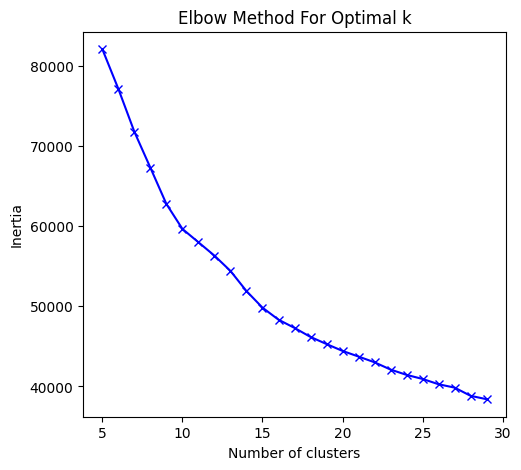

In [232]:
# Using KMeans to find different pitch profiles.
# Using spinrate, relspeed, horzbreak, inducedvertbreak, vertbreak, 
# platelocside, 'initposx', 'initposz'

# Subset of ~50k rows
bip_df_50k = bip_df.sample(n=20_000, random_state=42)

X_pitches = bip_df_50k[['spinrate', 'relspeed', 'horzbreak', 'inducedvertbreak',
                 'vertbreak', 'platelocside', 'initposx', 'initposz']].dropna()
# Scale data
scaler_pitches = StandardScaler()
X_scaled_pitches = scaler.fit_transform(X_pitches)
# Determine optimal number of clusters using the elbow method and silhouette score
inertia = []
silhouette_scores = []
K = range(5, 30)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled_pitches)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled_pitches, kmeans.labels_))

# Plotting the elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

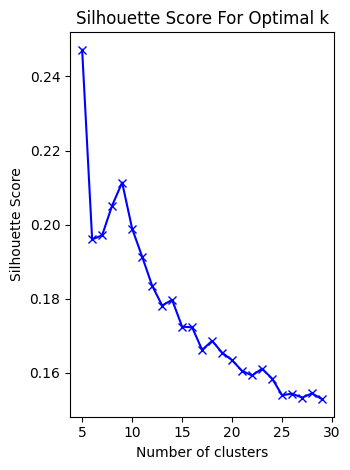

In [233]:
# Plotting the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.tight_layout()
plt.show()

In [229]:
bip_df['initposz']

10         6.069
19         5.441
21         5.532
31         6.026
34         6.013
           ...  
2134000    5.365
2134001    5.451
2134005    5.286
2134008    5.374
2134009    5.447
Name: initposz, Length: 372391, dtype: float64

7286 games between '22 and '24

## Cleaning the Data